#### Teoría de Circuitos II
<img src="./logo_UTN.svg" align="right" width="150" /> 

# Filtros Digitales no recursivos (FIR): Introducción
#### Dr. Ing. Mariano Llamedo Soria
Grupo de Investigación en Bioingeniería (GIBIO)


### Introducción

Este notebook está pensado para acompañar con ejemplos de aplicación, las explicaciones que se han dado previamente en clase, y algunas están grabadas en [formato audiovisual](https://www.youtube.com/watch?v=RHIQ7O6TR3Q&list=PLlD2eDv5CIe9_QZtKGEPw5LtQRD3xaAnV&index=1).
Recordarles que analizaremos dos grandes tipos de filtros digitales: recursivos, o de respuesta **infinita** al impulso (IIR), o NO recursivo, es decir de respuesta **finita** al impulso (FIR). Para estudiar los IIR en TC2 nos valemos de todo el estudio previo de los filtros analógicos, sin embargo no tenemos esa posibilidad con los FIR, dado que no hay sistemas analógicos que se puedan comportar de esa manera. 

Una posible forma de comenzar con el estudio de los filtros FIR es a partir de la ecuación de diferencias:

\begin{equation}
y[k] = \sum_{m=0}^{M} b_m \; x[k-m] - \sum_{n=1}^{N} a_n \; y[k-n] \label{eq:ec_dif}
\end{equation}

Recordar que el término $a_0 = 1$ y su efecto se distribuye en el resto de los coeficientes $a_n$ y $b_m$. Queda claro que para los filtros FIR, los coeficientes $a_n=0$ para que no haya recursión posible, es decir dependencia de salidas pasadas en el valor de la salida actual.

A continuación haremos una presentación de las herramientas de análisis y diseño provistas por el módulo [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html#filter-design), al mismo tiempo que repasamos algunos FIR elementales. Se comienza con la inicialización y definiciones de funciones de análisis:
    

In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})


def plot_frequency_response(tfz):
    # Calculate frequency response
    w, h = sig.freqz(tfz.num, tfz.den)

    # Normalize frequency axis
    freq_normalized = w / np.pi

    # Create a figure with vertical layout
    fig = plt.figure(figsize=(20, 24))

    # Plot Módulo
    ax1 = fig.add_subplot(311)
    ax1.plot(freq_normalized, 20 * np.log10(np.abs(h)))
    ax1.set_title('Respuesta de Módulo')
    ax1.set_ylabel('Módulo [dB]')
    ax1.grid()
    ax1.annotate('', xy=(1, 0), xytext=(0, 0),
                  arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=1))
    ax1.set_xlim(0, 1)

    # Plot Fase
    ax2 = fig.add_subplot(312)
    ax2.plot(freq_normalized, np.angle(h))
    ax2.set_title('Respuesta de Fase')
    ax2.set_ylabel('Fase [rad.]')
    ax2.grid()
    ax2.annotate('', xy=(1, 0), xytext=(0, 0),
                  arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=1))
    ax2.set_xlim(0, 1)

    # Plot group delay
    ax3 = fig.add_subplot(313)
    gd = -np.diff(np.unwrap(np.angle(h))) / np.diff(w)
    ax3.plot(freq_normalized[1:], gd)
    ax3.set_title('Retardo de Grupo')
    ax3.set_xlabel('Frecuencia normalizada')
    ax3.set_ylabel('Retardo de Grupo [muestras]')
    ax3.grid()
    ax3.annotate('', xy=(1, 0), xytext=(0, 0),
                  arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=1))
    ax3.set_xlim(0, 1)
    
    # Find maximum delay and set plot limits
    max_delay_samples = np.ceil(np.max(gd))
    ax3.set_ylim(0, max_delay_samples)

    # Plot poles and zeros in a separate figure
    plt.figure(figsize=(8, 8))
    plt.plot(np.real(tfz.zeros), np.imag(tfz.zeros), 'o', color='blue', markersize=10, fillstyle='none', markeredgewidth=2, label='ceros')
    plt.plot(np.real(tfz.poles), np.imag(tfz.poles), 'x', color='red', markersize=10, markeredgewidth=2, label='polos')
    
    # Plot unit circle
    unit_circle = plt.Circle((0, 0), 1, color='gray', linestyle='--', fill=False)
    plt.gca().add_patch(unit_circle)
    
    plt.title('Polos y ceros')
    plt.xlabel('Real')
    plt.ylabel('Imaginario')
    plt.legend()
    plt.grid()
    
    # Add double-ended arrows from plot edges
    xlim = plt.xlim()
    ylim = plt.ylim()
    arrowprops = dict(facecolor='black', arrowstyle='<->', linewidth=1)
    plt.annotate('', xy=(xlim[0], 0), xytext=(xlim[1], 0), arrowprops=arrowprops)
    plt.annotate('', xy=(0, ylim[0]), xytext=(0, ylim[1]), arrowprops=arrowprops)

    plt.tight_layout()
    plt.show()


Ahora se analizarán los siguientes filtros FIR elementales:

* Pasabajos
* Pasa-altos
* Pasabanda

aprovechando el repaso para revisar las herramientas de análisis de sistemas digitales.

### Pasabajo de primer orden

Podemos pensar un [pasabajos elemental](https://www.youtube.com/watch?v=D44pOaPoARs&list=PLlD2eDv5CIe9_QZtKGEPw5LtQRD3xaAnV&index=15) como la suma de la muestra actual y la inmediata anterior:

$$ y(k) = x(k) + x(k-1) $$

cuya transformada $Z$ es

$$ Y(z) = X(z) + X(z) . z^{-1} =  X(z) (1 + z^{-1}) $$

y su transferencia en consecuencia

$$ \frac{Y(z)}{X(z)} = H(z) = (1 + z^{-1}) = \frac{z + 1}{z} $$

se observa que este sistema elemental tiene un cero en z = -1 y un polo en z = 0. Y si se compara la expresión de $y(k)$ con la ecuación de diferencias, comprendemos que el filtro solo se compone de coeficientes $b_m$, como no puede ser de otra manera en los filtros FIR todos los $a_n=0$ salvo $a_0 = 1$. Traducimos esto a *Python*

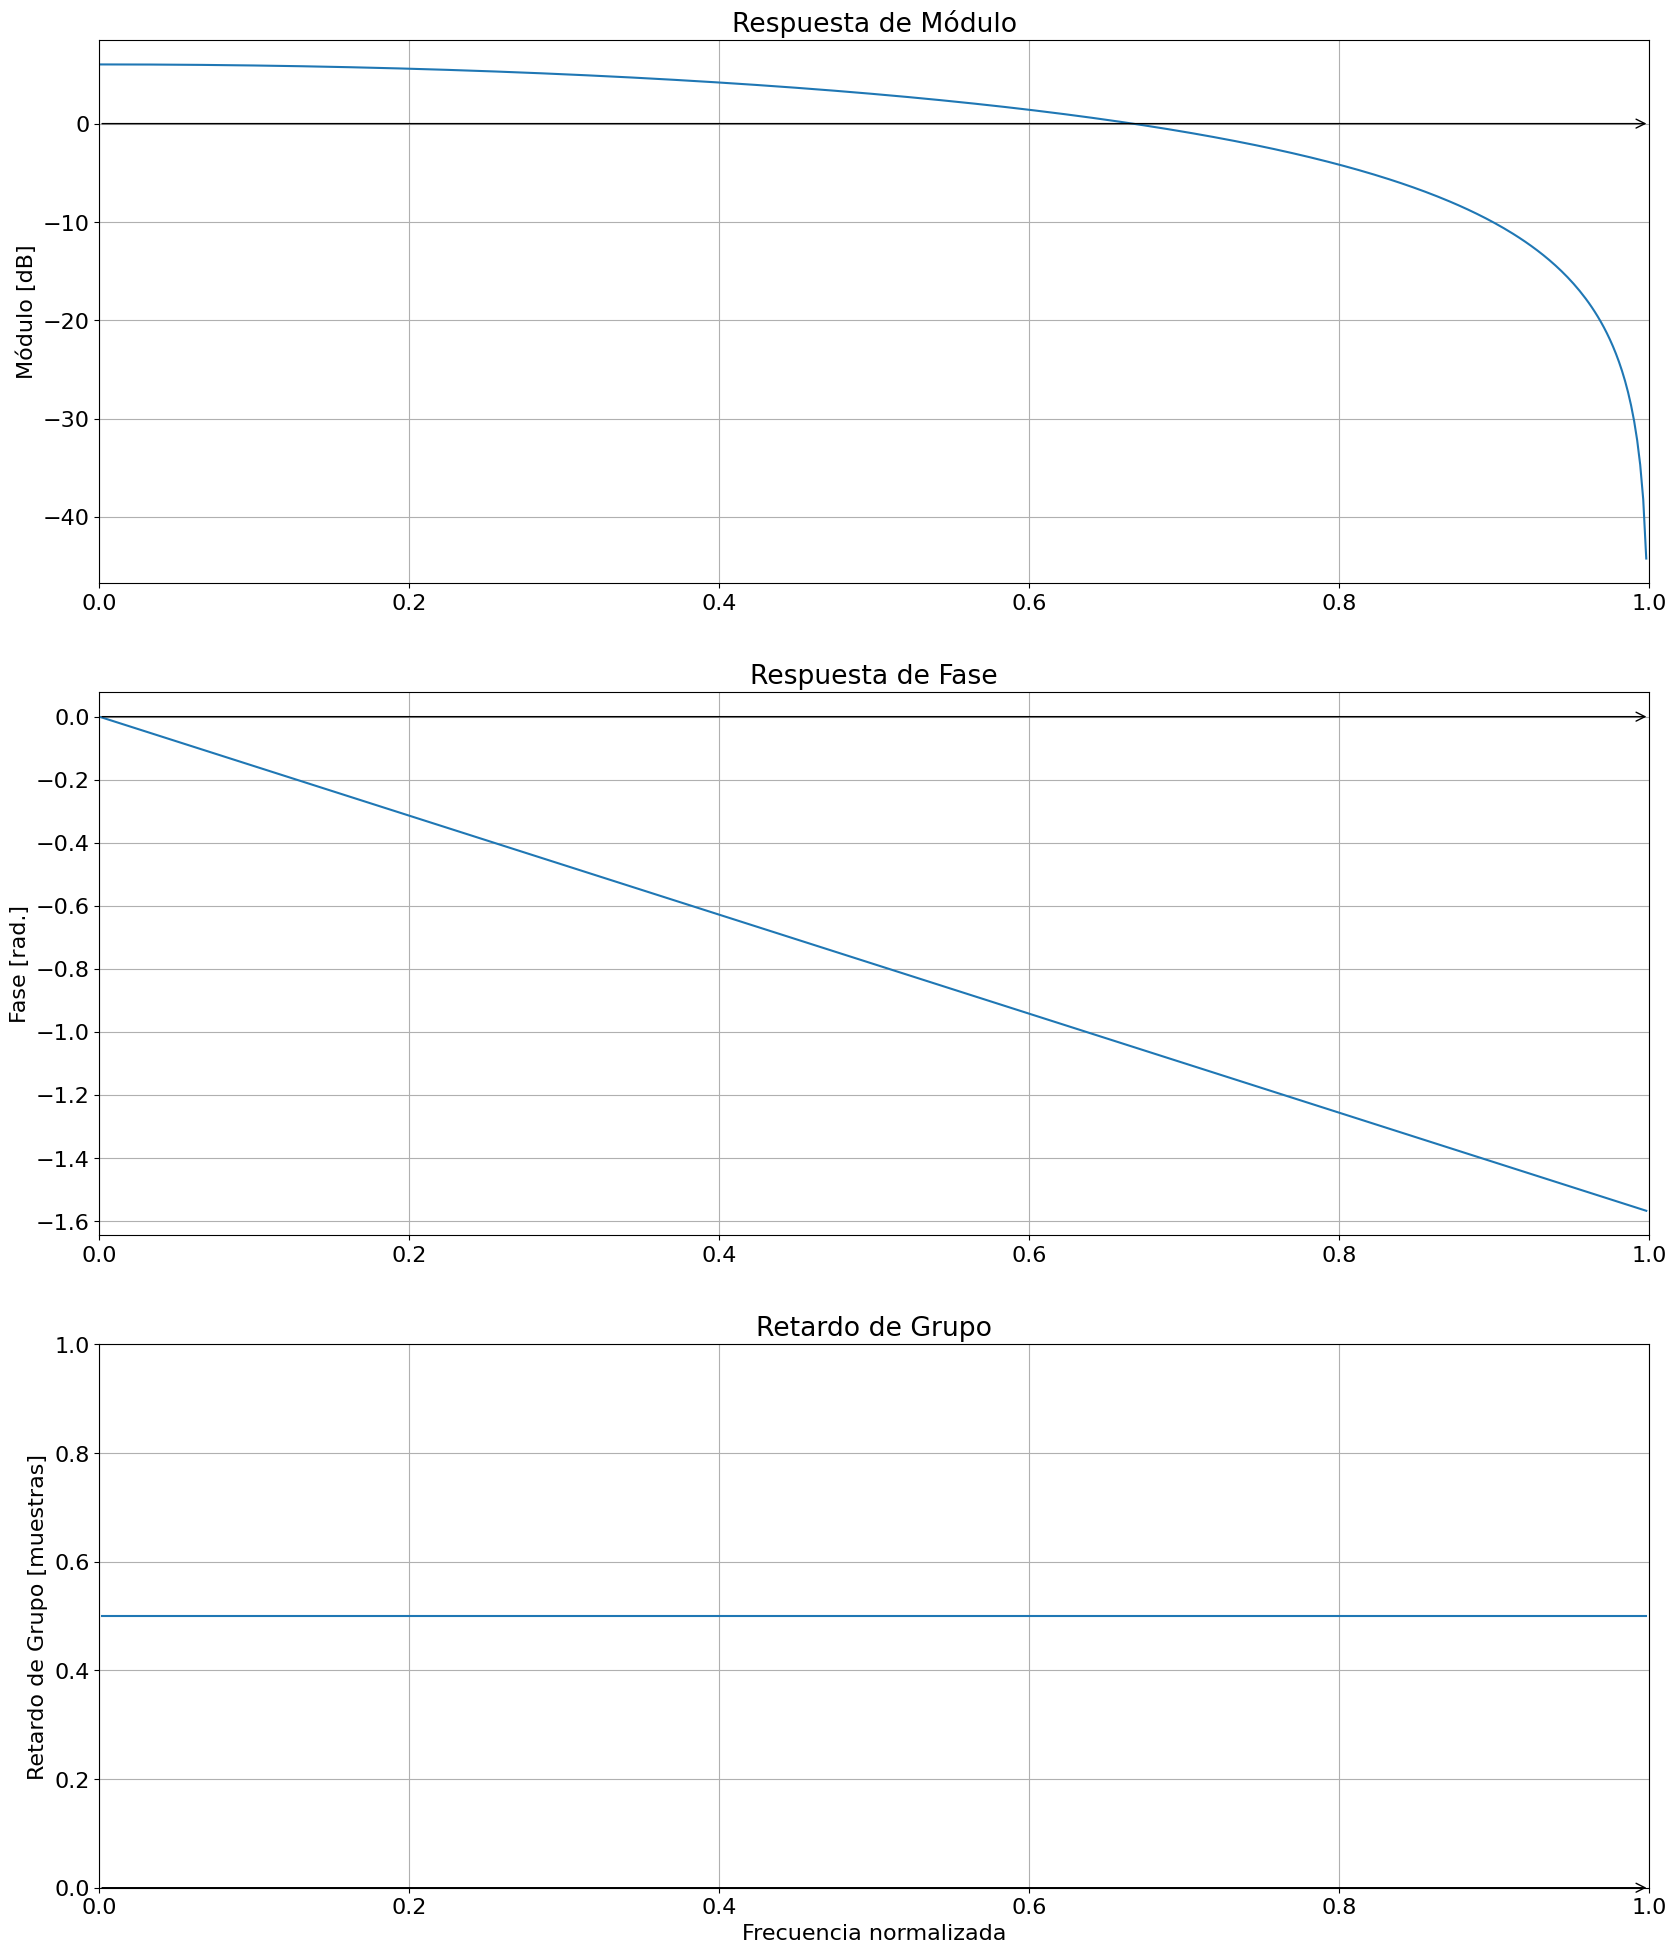

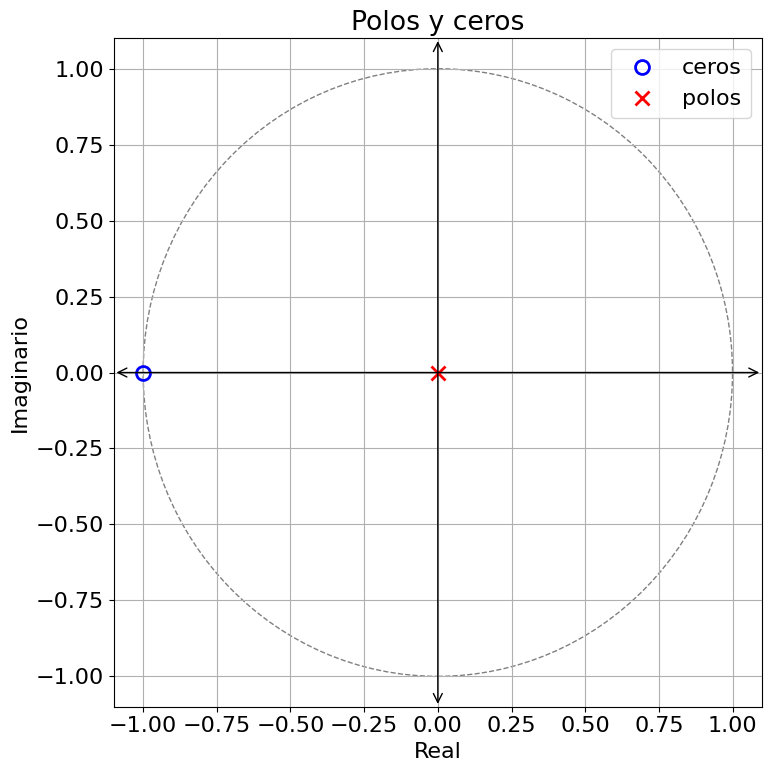

In [2]:
# planteamos dos vectores para no perder generalidad en los siguientes ejemplos
bm =  np.array([1, 1])
an =  np.array([1, 0])

# planteamos una fs = 2 Hz, de modo tal que Nyqyuist = 1 Hz y tengamos el 
# "ancho de banda" digital normalizado.
fs = 2
my_df = sig.TransferFunction(bm, an, dt=1/fs)
plot_frequency_response(my_df)



### Pasabajos de órdenes superiores

Extendiendo la idea del pasabajo de primer orden se puede ampliar al extender la ventana considerada en la suma a $M$ muestras, y así llegar a:

$$ y(k) = \sum_{m=0}^{M} x(k-m) $$

para llegar a una transferencia

$$ H(z) = \sum_{m=0}^{M} z^{-m} = \frac{\sum_{m=0}^{M} z^{m} }{z^M} $$

nótese la similitud de la expresión a un promedio de $M$ muestras, salvo por estar fuera de escala (1/$M$) el resultado. Así y todo, la respuesta del sistema sigue siendo un pasabajo con $M-1$ ceros equiespaciados en el círculo unitario, salvo que tiene una ganancia de 20.log(M) dB en DC. 

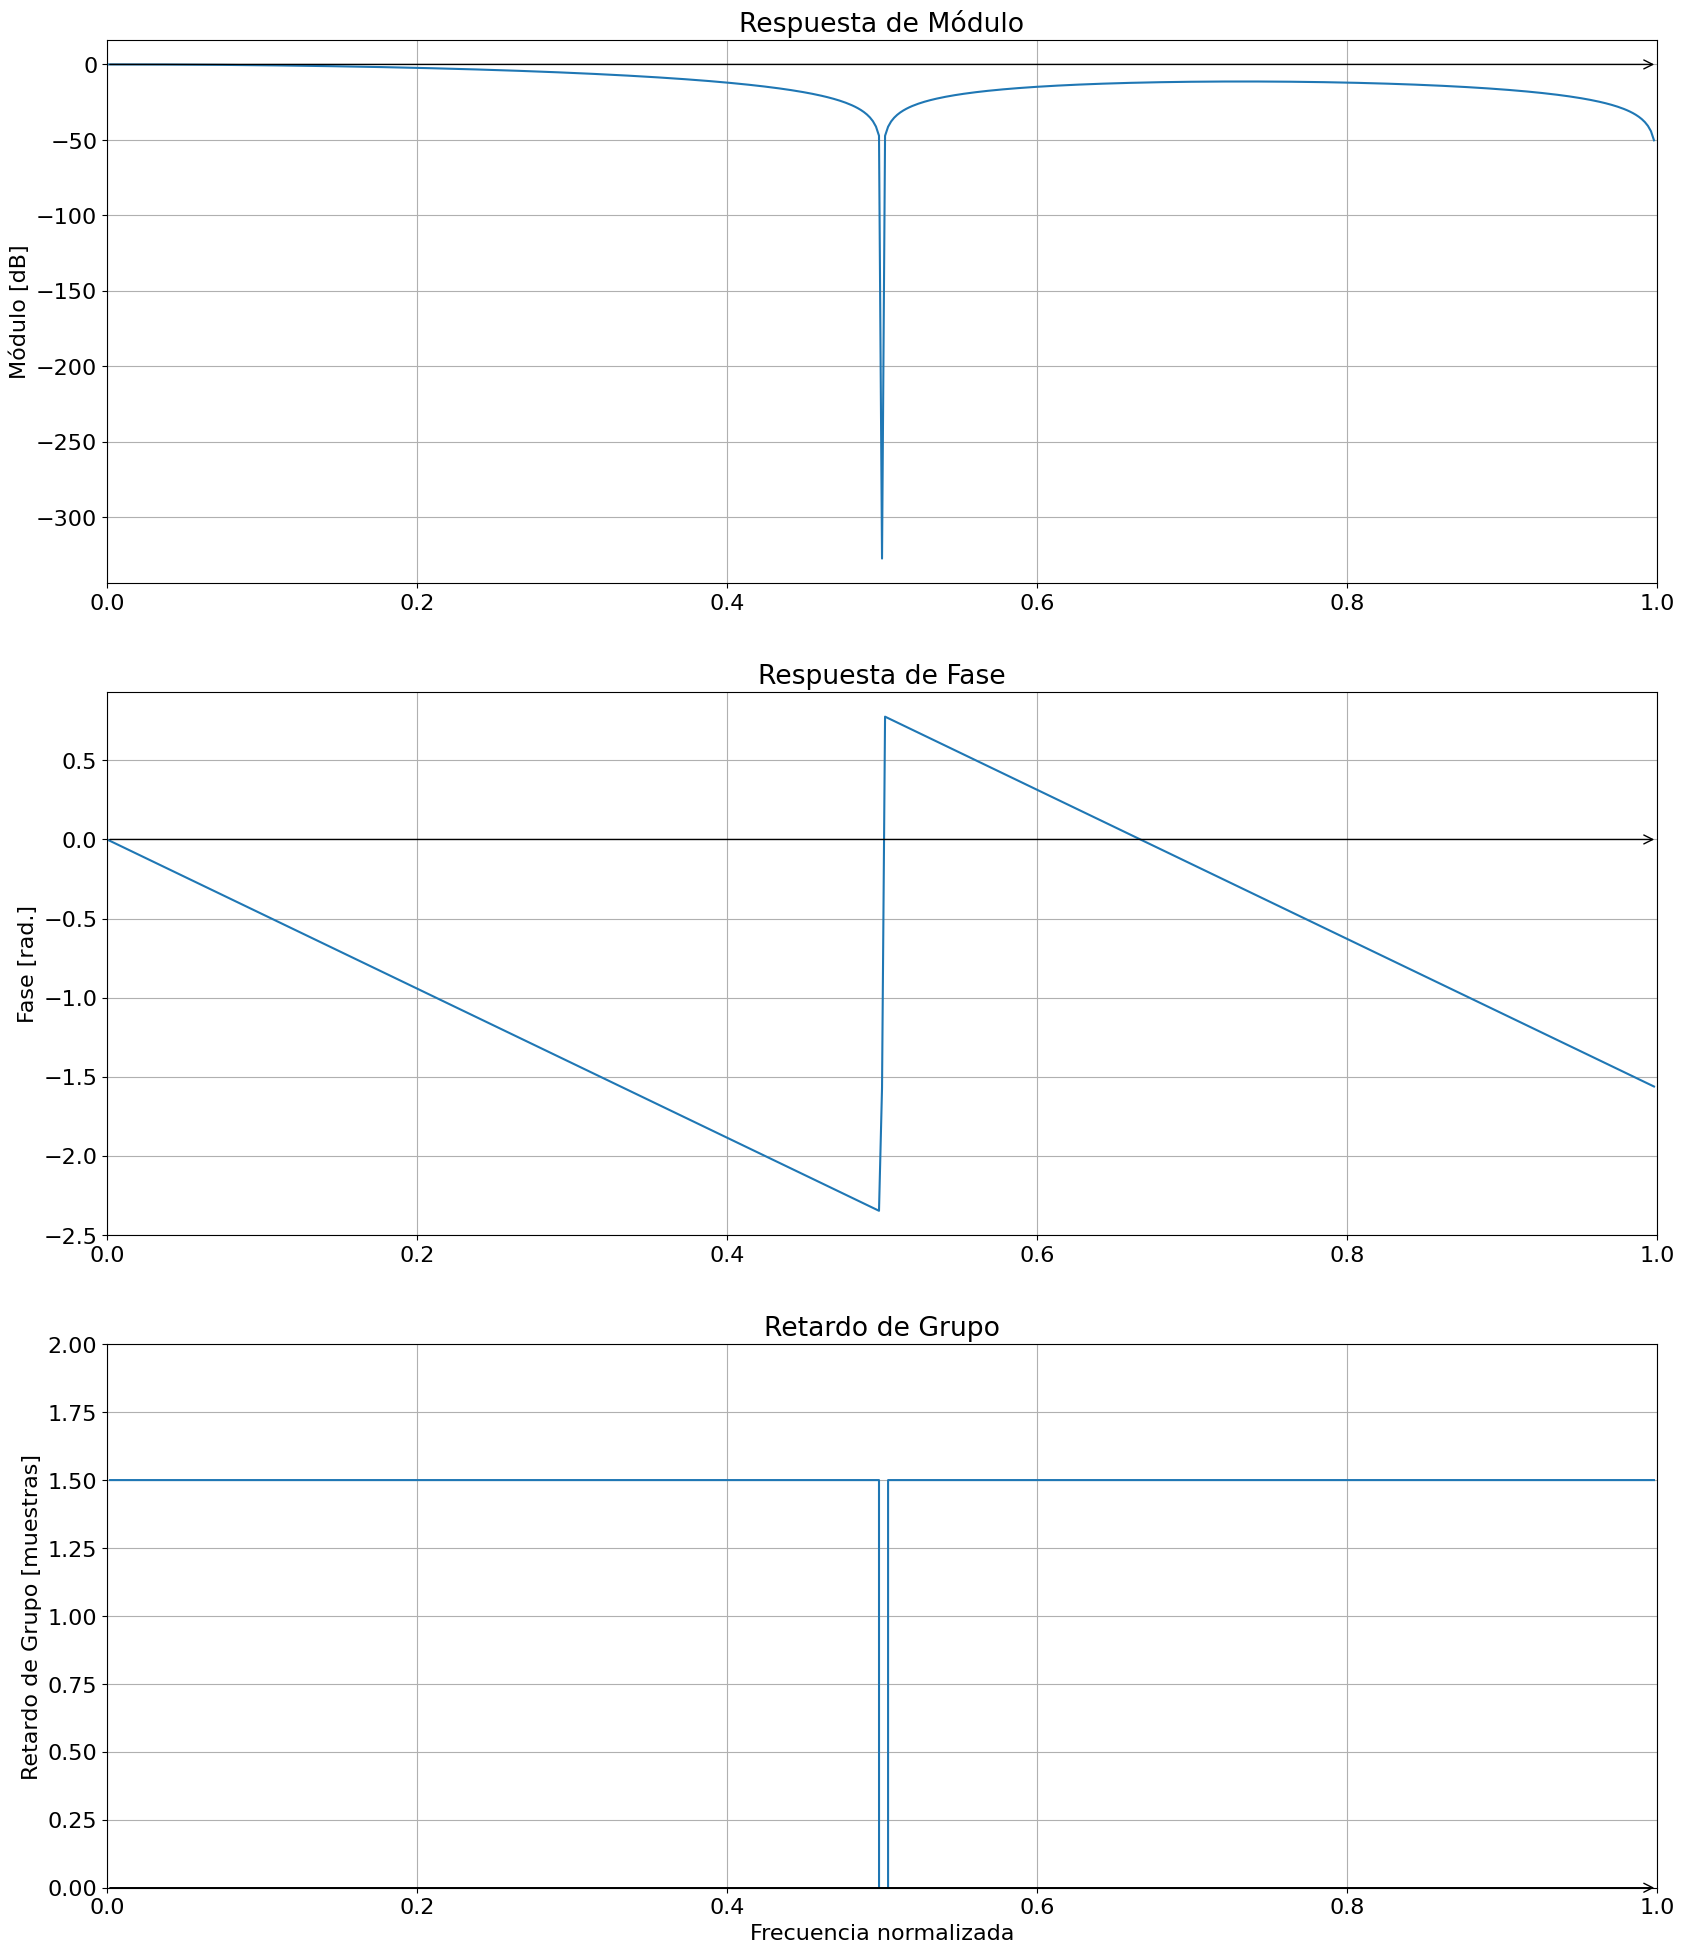

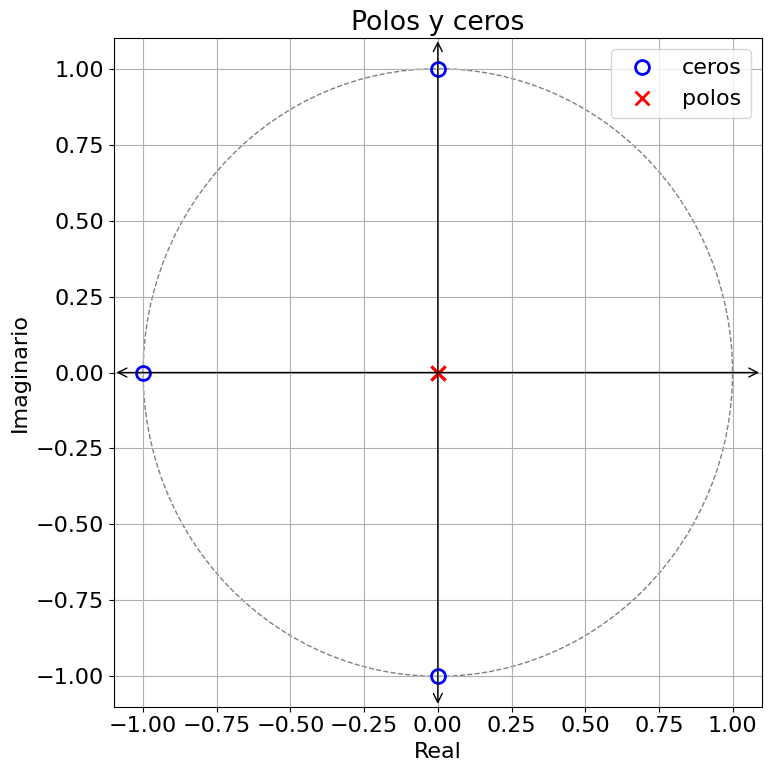

In [3]:
# planteamos dos vectores para no perder generalidad en los siguientes ejemplos
M = 4
bm =  1/M * np.ones(M)
an =  np.hstack([1, np.zeros(M-1)])

# planteamos una fs = 2 Hz, de modo tal que Nyqyuist = 1 Hz y tengamos el 
# "ancho de banda" digital normalizado.
fs = 2
my_df = sig.TransferFunction(bm, an, dt=1/fs)
plot_frequency_response(my_df)



Se sugiere cambiar la escala 1/M de los coeficientes $b_m$ y variar el valor de ventana M como ejercicio final. También puede observarse el resultado de elegir M par al forzar un cero en la transferencia para f = 1 (Nyquist). 

### Pasa-altas

En este caso se plantea la diferencia entre muestras adyacentes como punto de partida para entender una transferencia pasa-altas

$$ y(k) = x(k) - x(k-1) $$

para llegar a una transferencia en z

$$ H(z) = 1 - z^{-1} = \frac{z - 1}{z} $$

Anticipamos la evidente ocurrencia de un cero en z = 1, es decir en DC, veremos qué arroja la simulación en scipy

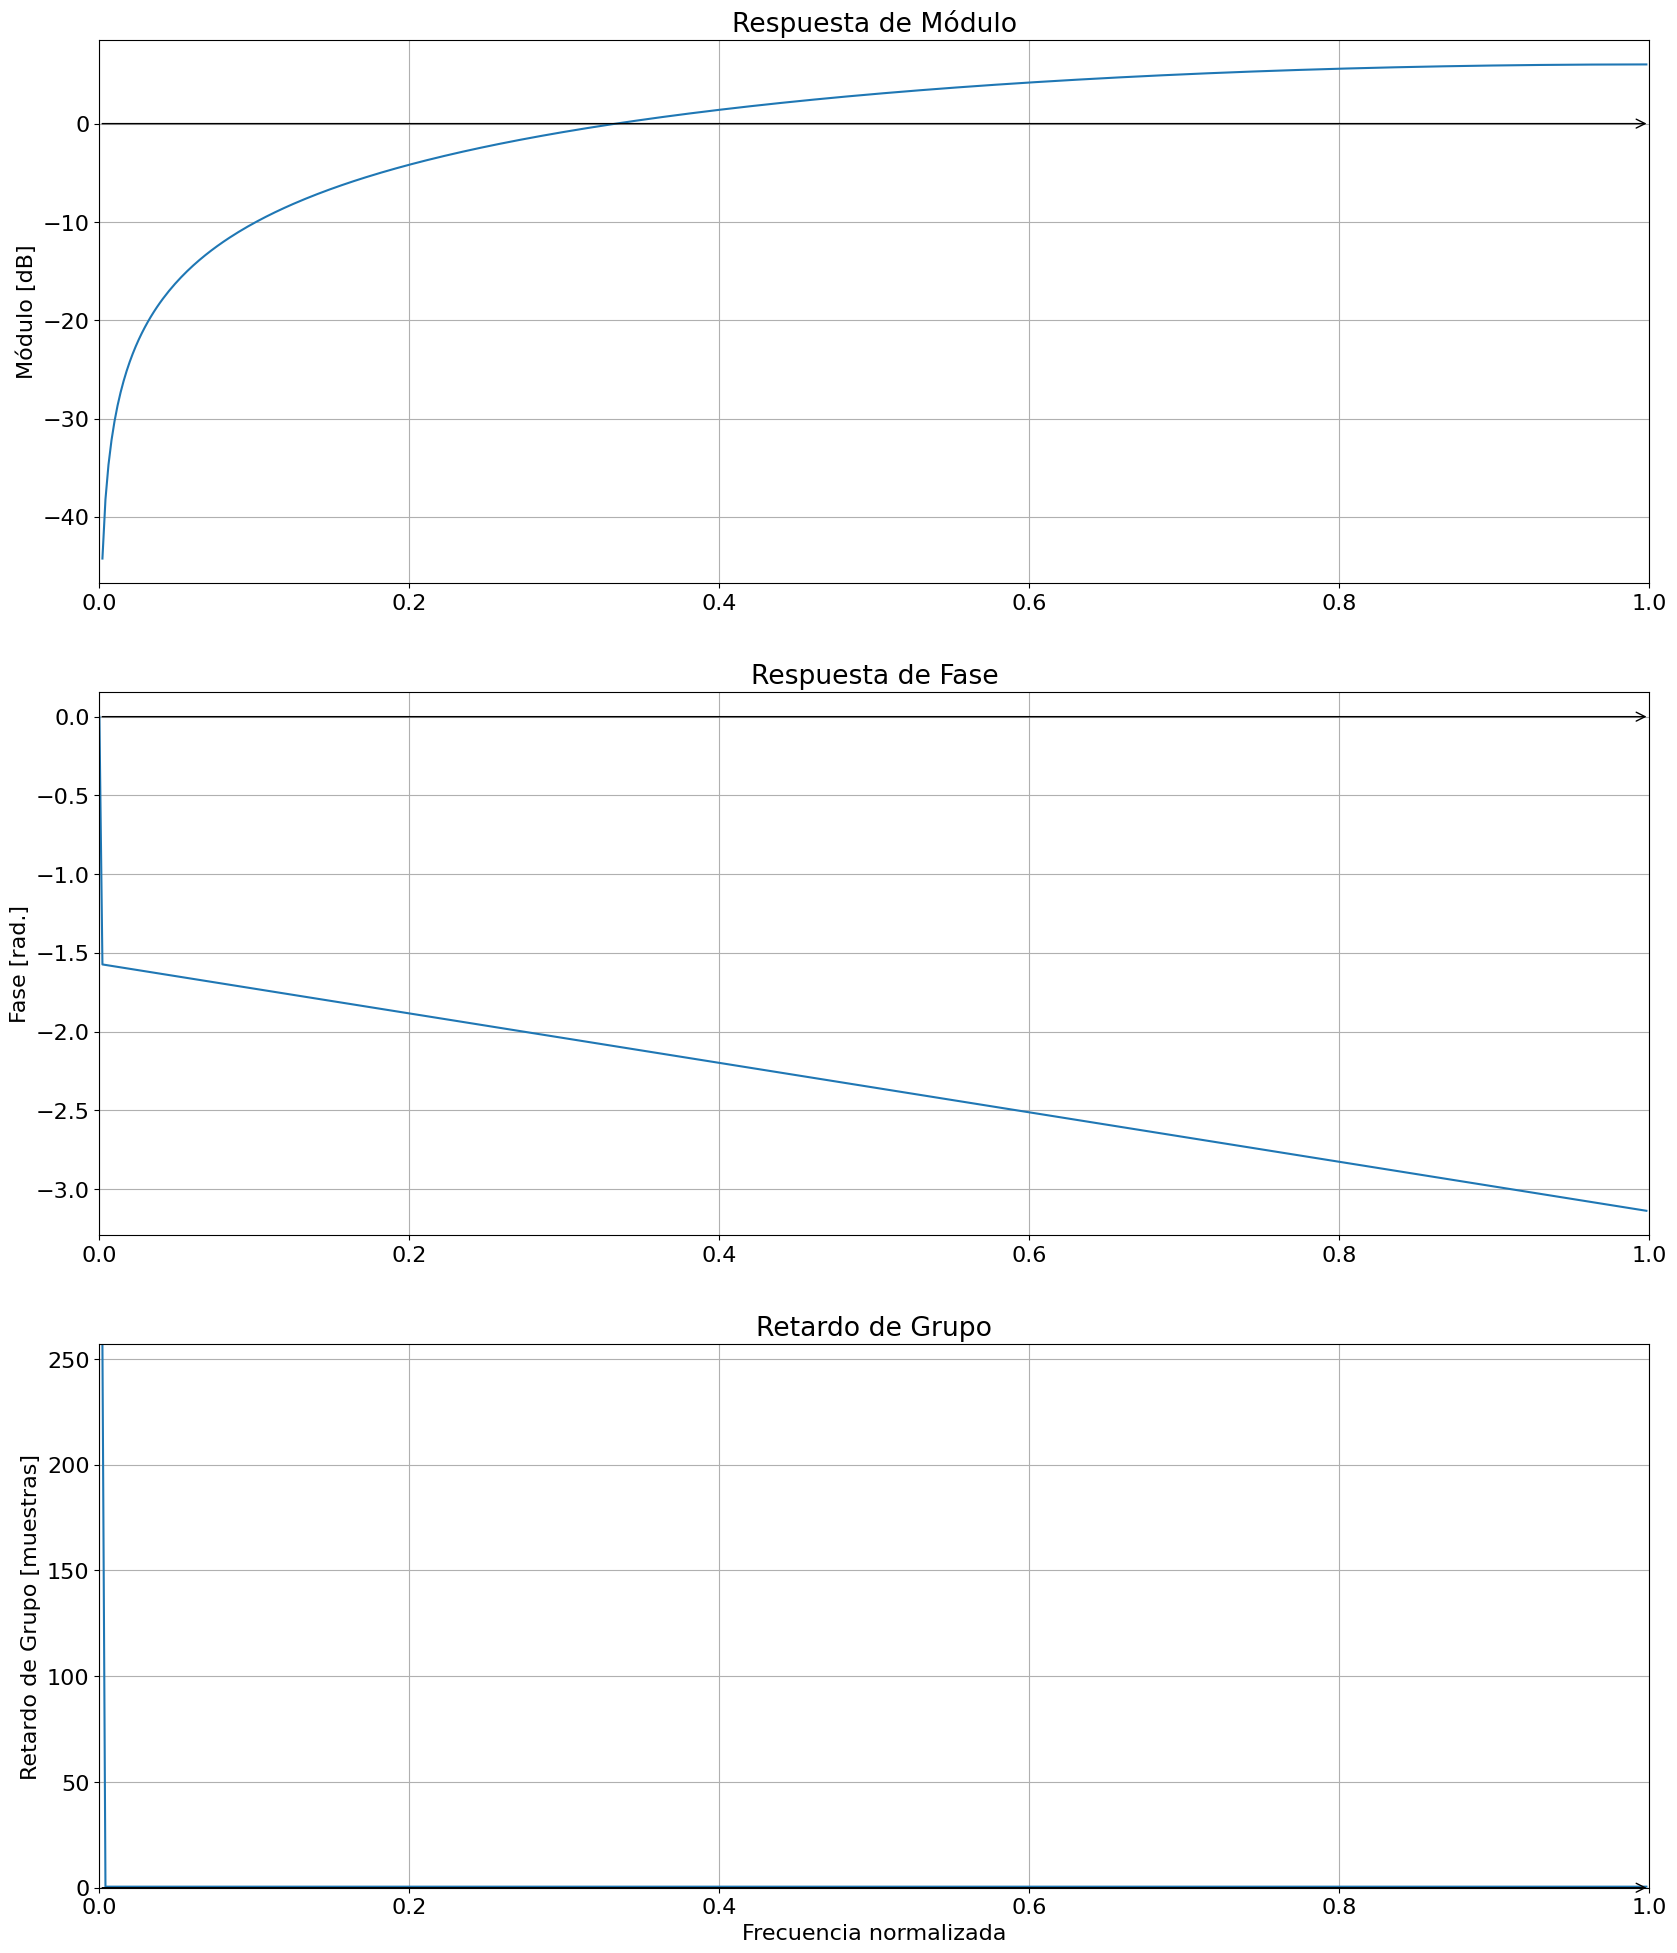

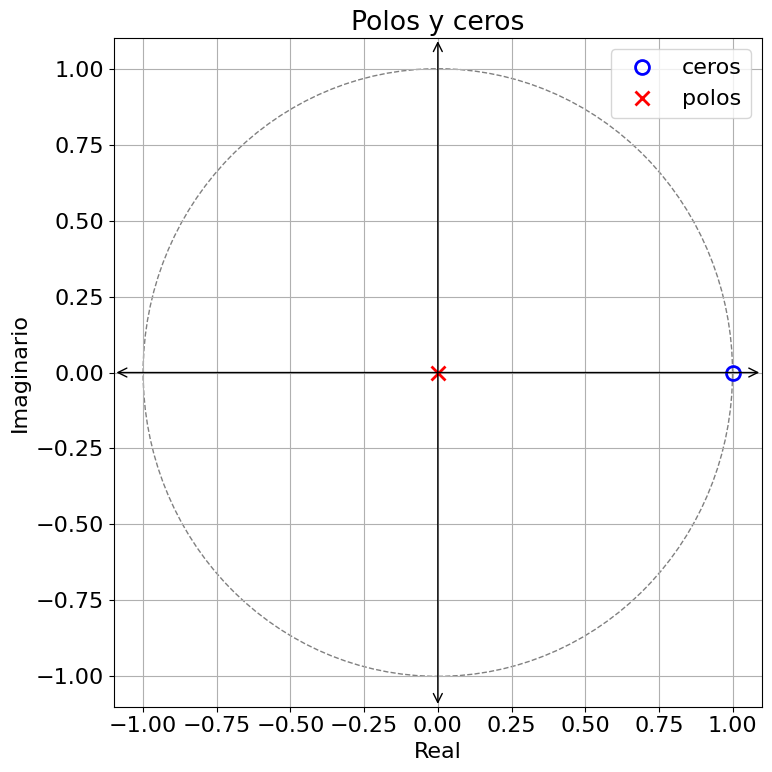

In [4]:
# planteamos dos vectores para no perder generalidad en los siguientes ejemplos
bm =  np.array([-1, 1])
an =  np.array([1, 0])

# planteamos una fs = 2 Hz, de modo tal que Nyqyuist = 1 Hz y tengamos el 
# "ancho de banda" digital normalizado.
fs = 2
my_df = sig.TransferFunction(bm, an, dt=1/fs)
plot_frequency_response(my_df)



Algunas **observaciones y alertas**. Las especialmente con los problemas numéricos que acarrea el cálculo del retardo de grupo. Aparentemente el retardo es extremadamente alto, cosa que no condice con la teoría ya que el retardo debería ser de 1/2 muestra, al igual que el pasabajo de primer orden. Sin embargo, el cero en el origen provoca una discontinuidad de la fase que afecta al cálculo numérico de la derivada. Quienes se interesen en la cuestion pueden experimentar retirando el primer valor de la fase, y obtener el retardo real del sistema.

Una observación interesante: así como un filtro pasabajo se corresponde con la adición, y en consecuencia con la integración en el tiempo, la diferenciación tiene un claro correlato espectral con el comportamiento pasa-altas. Y de forma recíproca con la derivación o la estimación de la pendiente de una curva. Nótese que al ser

$$ y(k) = x(k) - x(k-1) = \Delta_y $$

y siendo que un derivador debería tener una salida 

$$ y(k) = \lim_{\Delta_x\to0} \frac{\Delta_y}{\Delta_x} $$ 

entonces se observa que para un $\Delta_x$ finito, éste no es otra cosa que una constante impuesta por el sistema de muestreo, es decir $\Delta_x = \frac{1}{f_s}$. En consecuencia, el filtro que vimos como pasa-altos, es un derivador fuera de escala.

### Pasabanda

Continuando el análisis del derivador o pasa-altas, si en lugar de tomar la diferencia respecto a la adyacente, distanciamos una muestra más, la salida ahora será 

$$ y(k) = x(k) - x(k-2) $$

entonces tendremos 

$$ H(z) = 1 - z^{-2} = \frac{z^2 - 1}{z^2} $$

y claramente se trata de un pasabanda elemental, dado que tanto en DC como en nyquist tenemos sendos ceros. Veamos la simulación

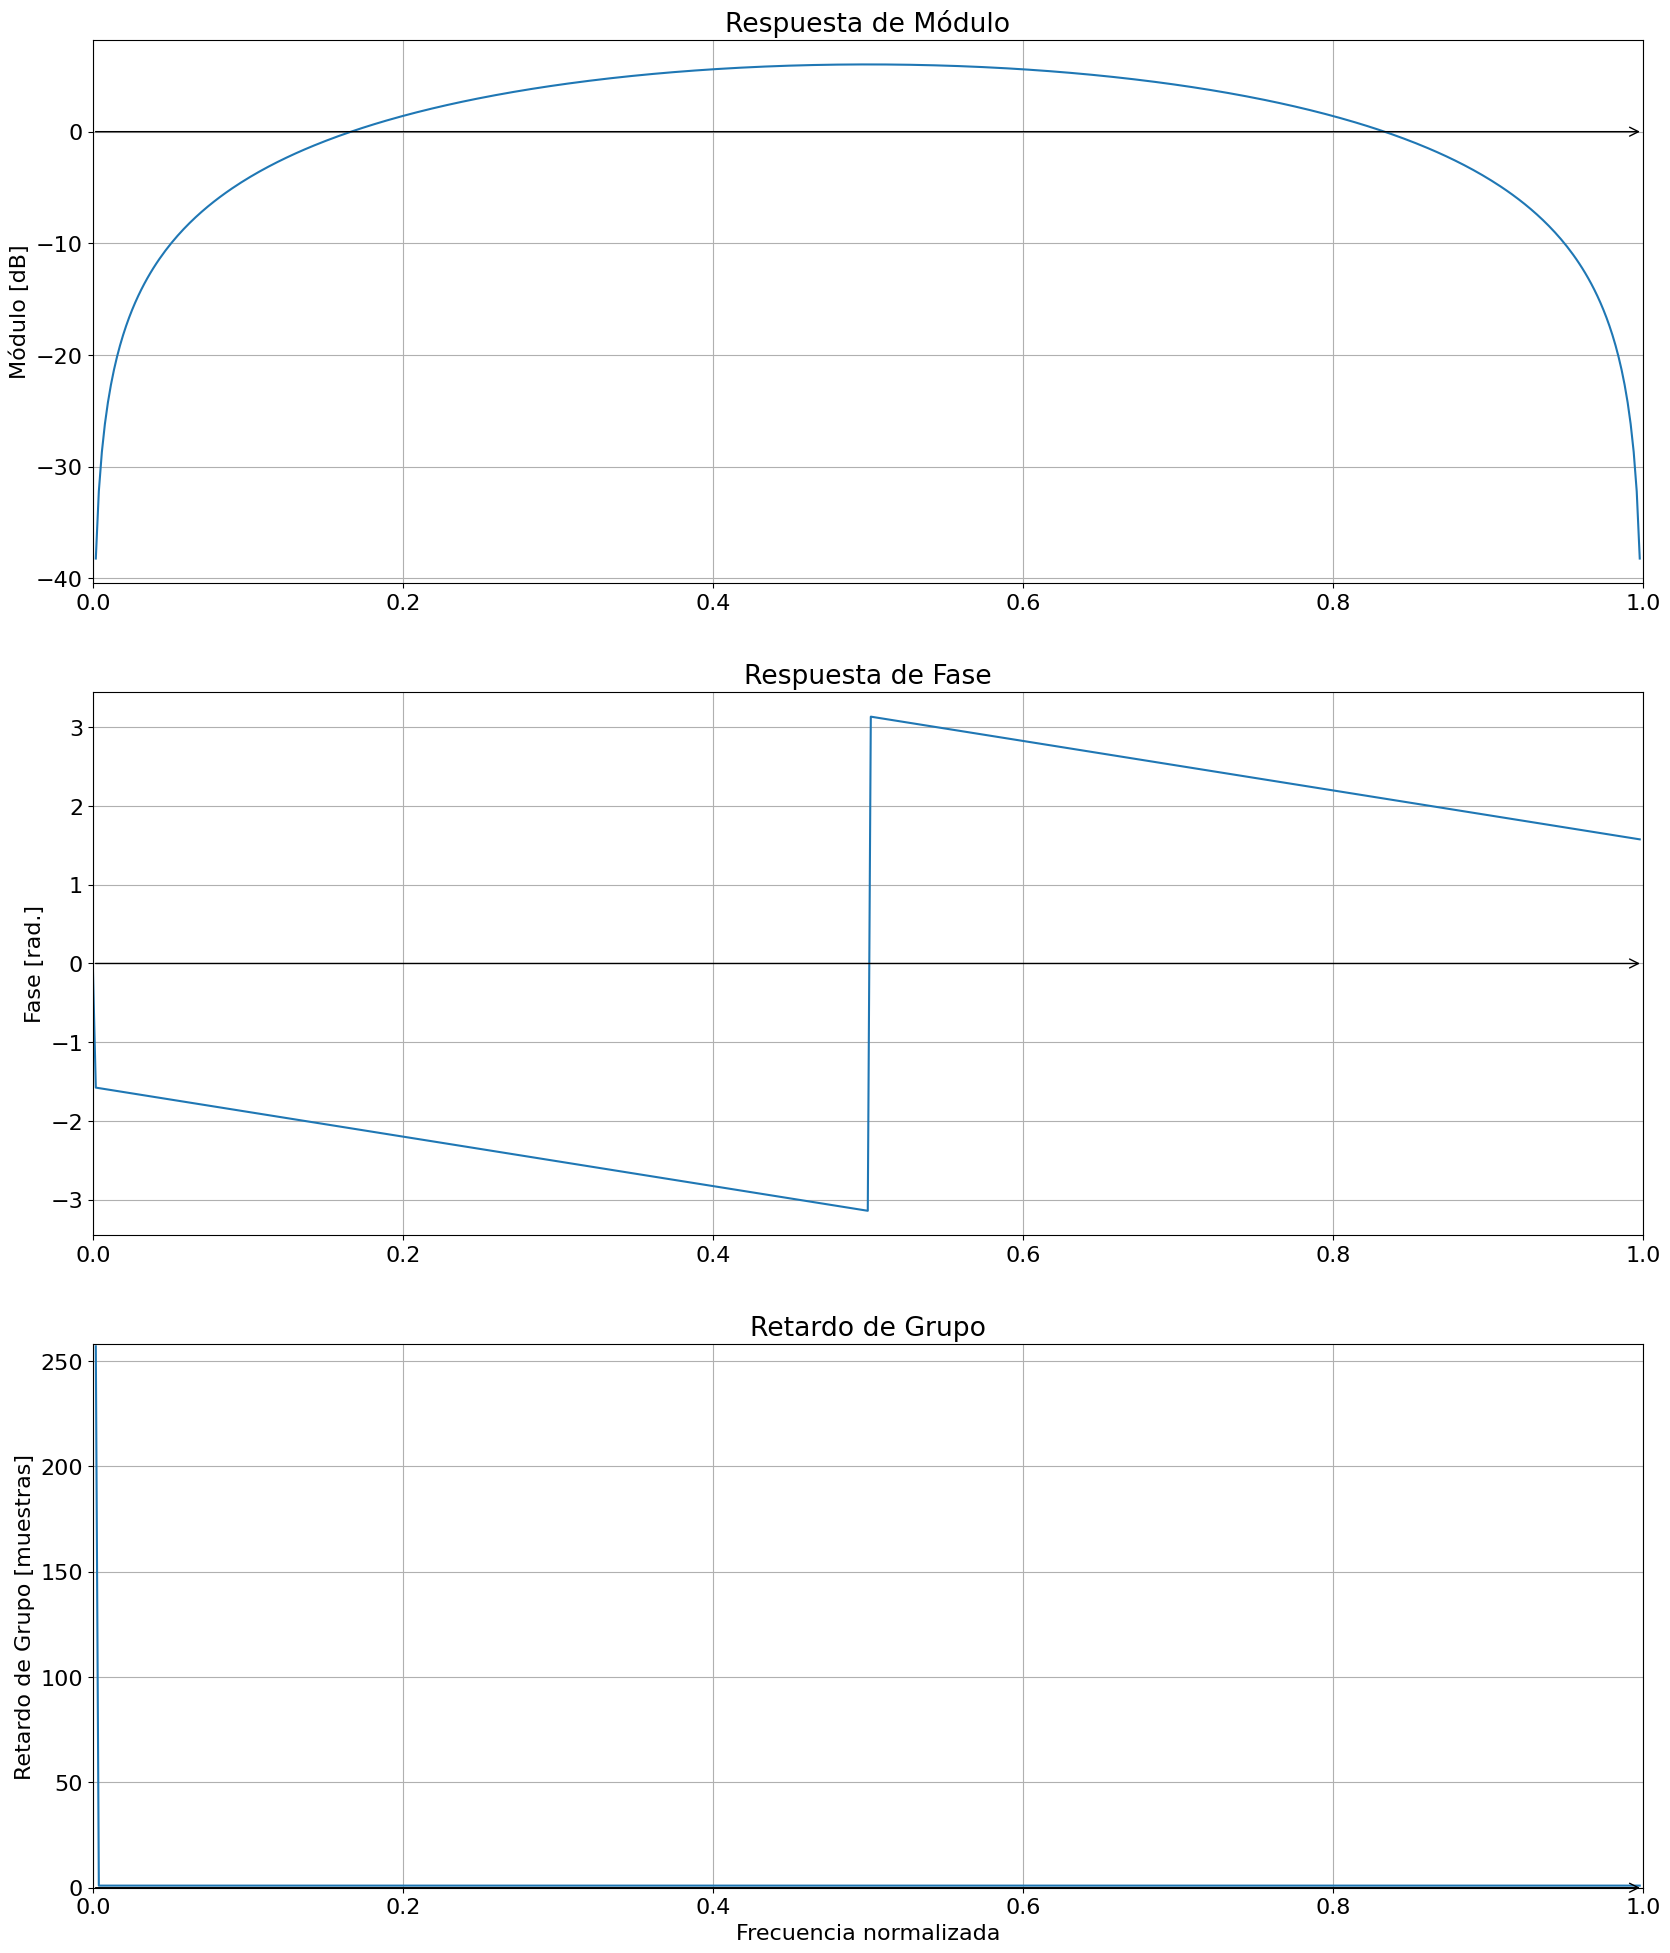

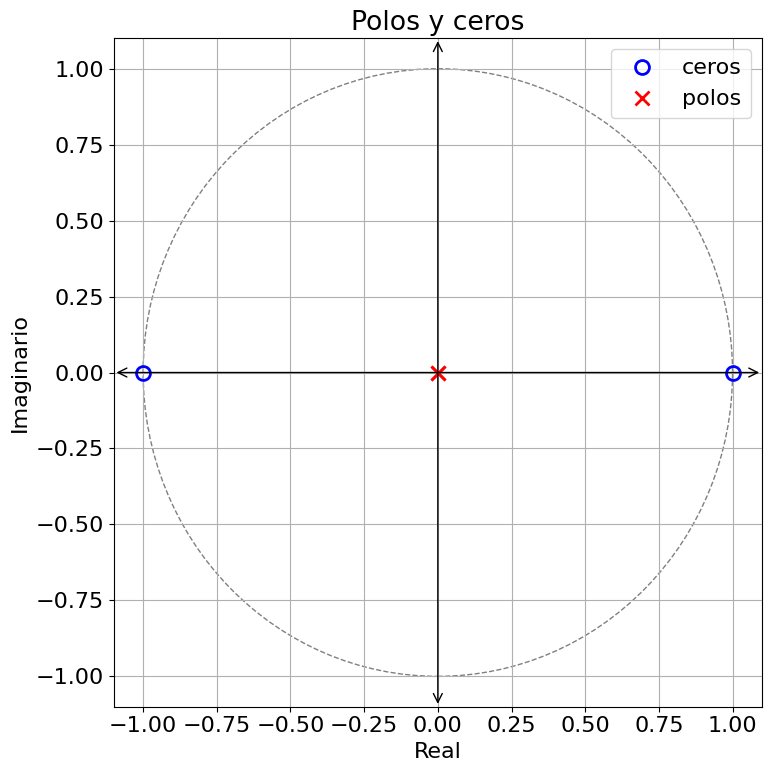

In [5]:
# planteamos dos vectores para no perder generalidad en los siguientes ejemplos
bm =  np.array([-1, 0, 1])
an =  np.array([1, 0, 0])

# planteamos una fs = 2 Hz, de modo tal que Nyqyuist = 1 Hz y tengamos el 
# "ancho de banda" digital normalizado.
fs = 2
my_df = sig.TransferFunction(bm, an, dt=1/fs)
plot_frequency_response(my_df)



Mismo comentario que con la transferencia pasa-altas, el retardo en este caso debería ser de **una muestra** para todas las frecuencias, pero el cero en el origen complica la estimación de la pendiente, quedando a cargo de quien lee verificar el resultado de la teoría.

Hasta acá se hizo una presentación de las transferencias **elementales** para el tipo de filtros digitales FIR, resta profundizar en cómo diseñar FIRs más elaborados que cumplan con plantillas de diseño más estrictas (en cuanto a su resp. de módulo al menos). Sin embargo, en todos los casos obtuvimos una respuesta de fase **exactamente lineal**, y en consecuencia un retardo constante que garantiza que cualquiera de los filtros revisados hasta el momento no producirán distorsión de envolvente o fase.

En la siguiente sección se presentará otra posibilidad que brinda el diseño digital, que es la interpolación y el diezmado, o lo que es equivalente, el cambio arbitrario de la frecuencia de operación de un sistema digital. Cabe destacar que ambas operaciones

### Interpolación de una transferencia

La operación de interpolación consiste en intercalar ceros entre cada muestra, o lo que es equivalente:

$$ H_i(Z) =  H(z) \Big\vert_{z = Z^U} $$

por simplicidad diferenciamos $Z$ de $z$, ya que la primera sería la nueva variable interpolada. En este caso la respuesta $ H_i(Z) $ se corresponde a la misma respuesta $ H(z) $, salvo que con U muestras iguales a cero entre cada muestra de su respuesta. Por ejemplo para el filtro pasa-altas cuya respuesta era

$$ H_{hp}(z) = 1 - z^{-1} $$ 

vemos que si consideramos $U = 2$ tendremos

$$ H_{bp}(Z) = H_{hp}(z)\Big\vert_{z = Z^2} = 1 - Z^{-2} $$ 

es decir que el pasa-altas se convirtió en el pasabanda que vimos anteriormente. Veamos ahora qué sucede si interpolamos por el mismo factor la respuesta del pasabajo.

$$ H_{lp}(z) = 1 + z^{-1} $$ 

entonces 

$$ H_{N}(Z) = H_{lp}(z)\Big\vert_{z = Z^2} = 1 + Z^{-2} $$ 

esta transferencia tiene ceros para $Z = \pm 1j $, veamos de qué se trata.

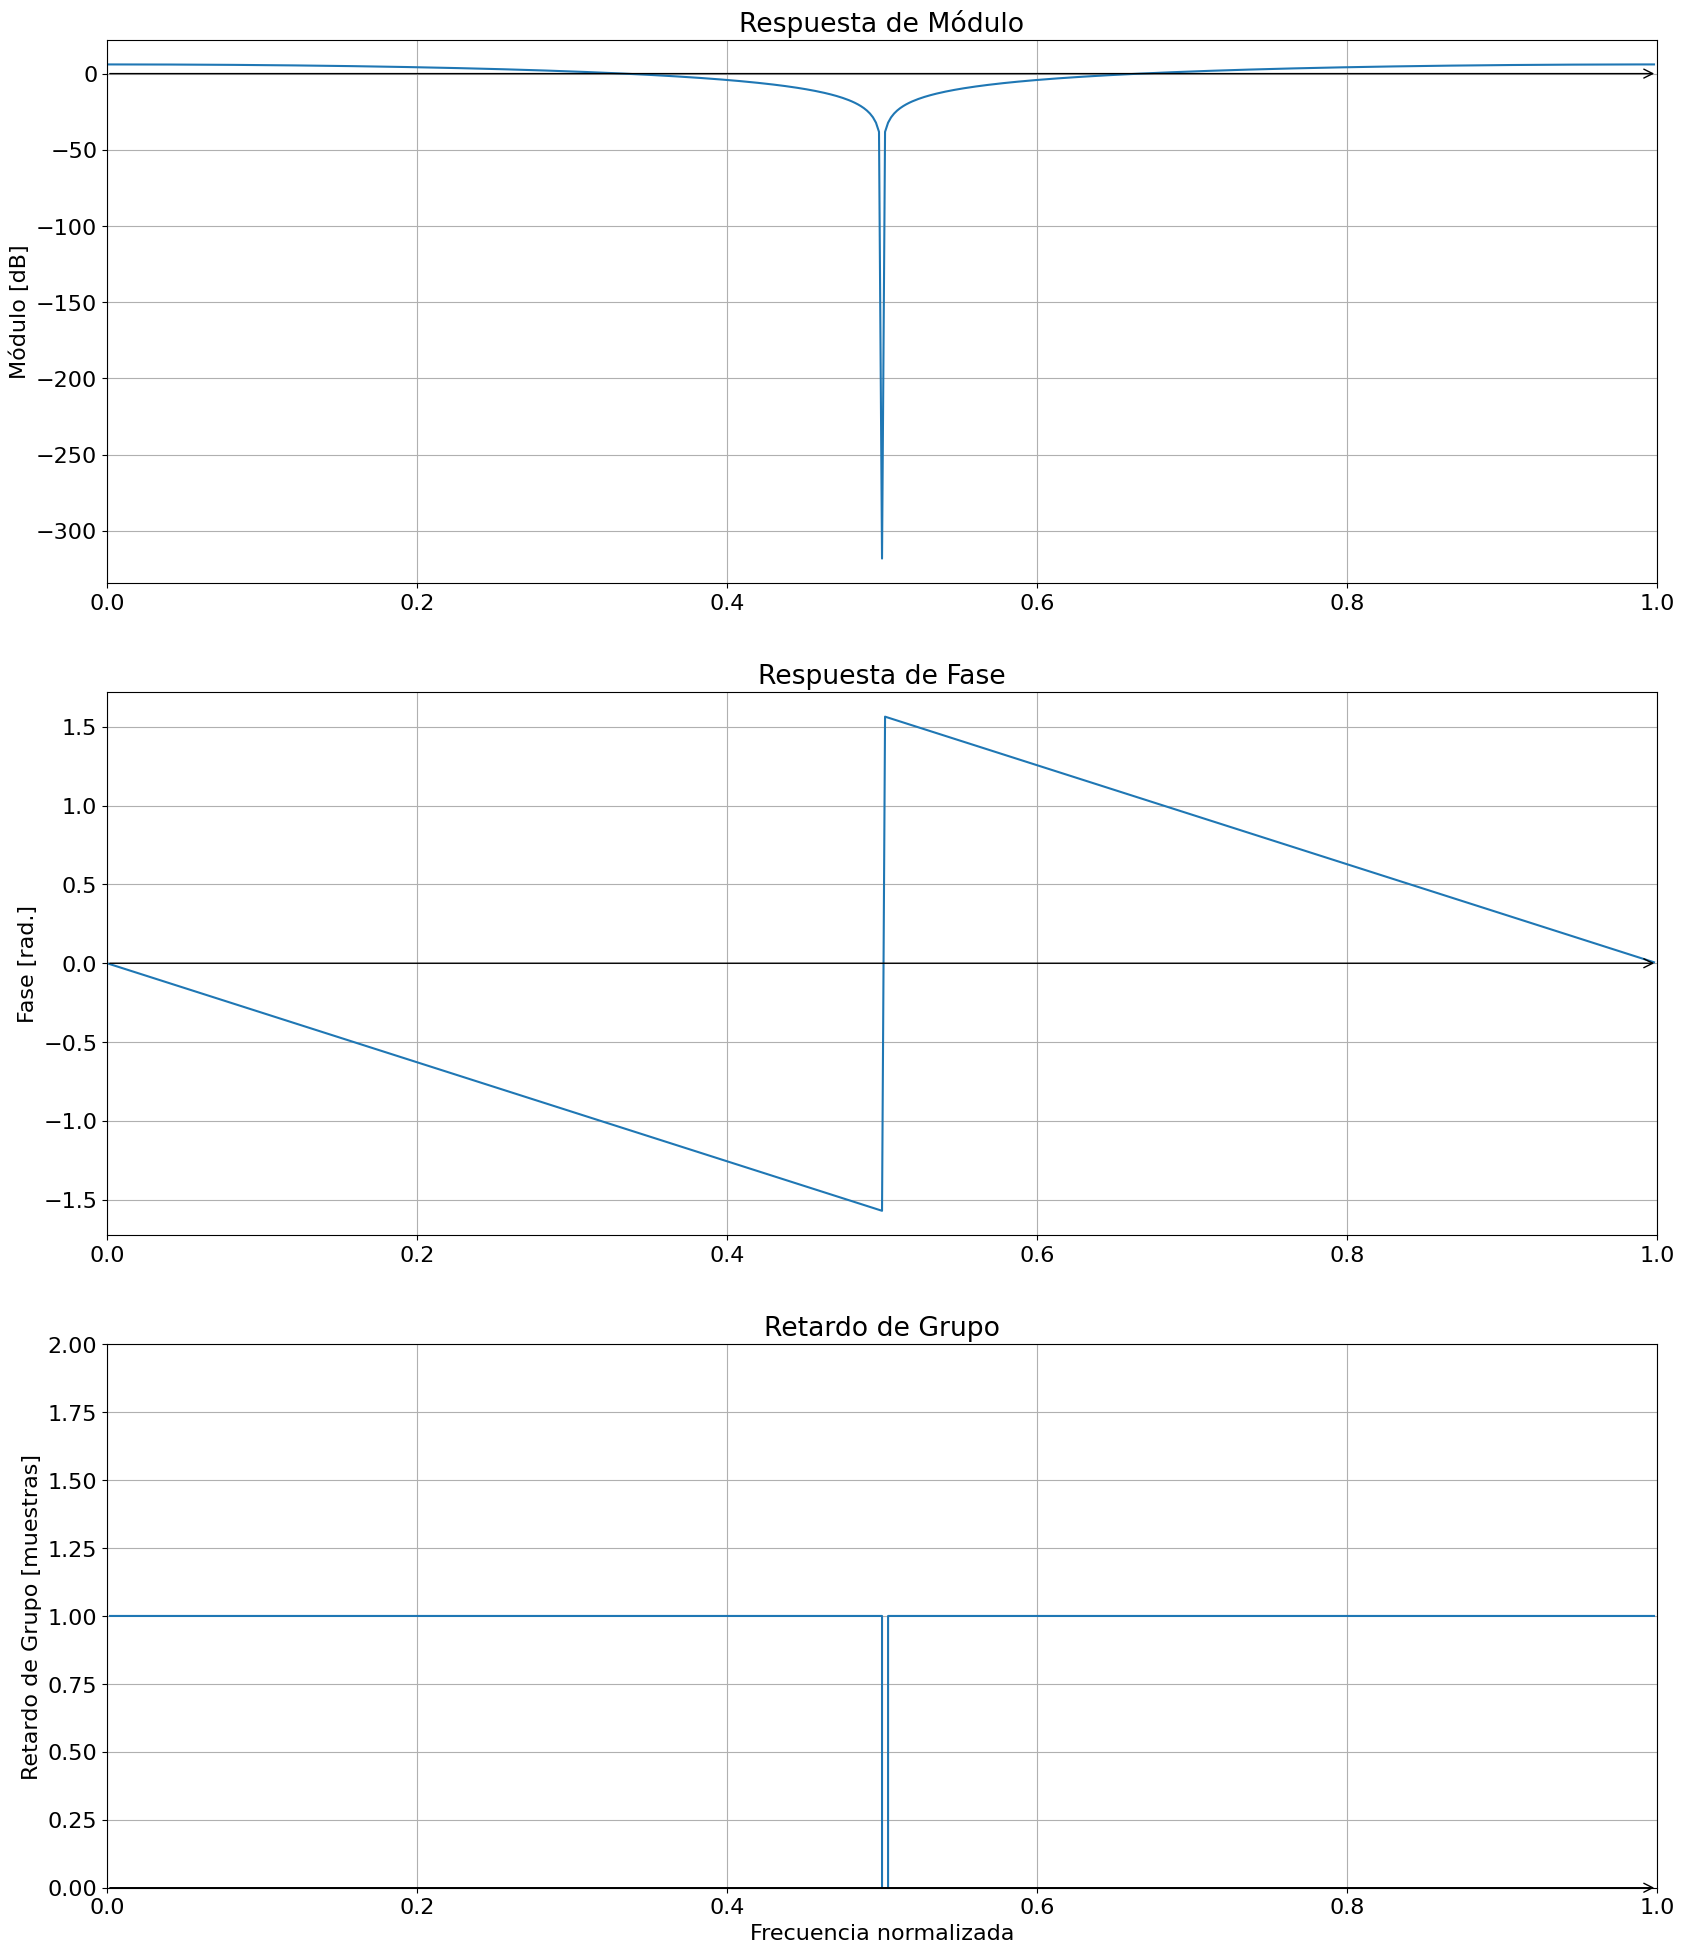

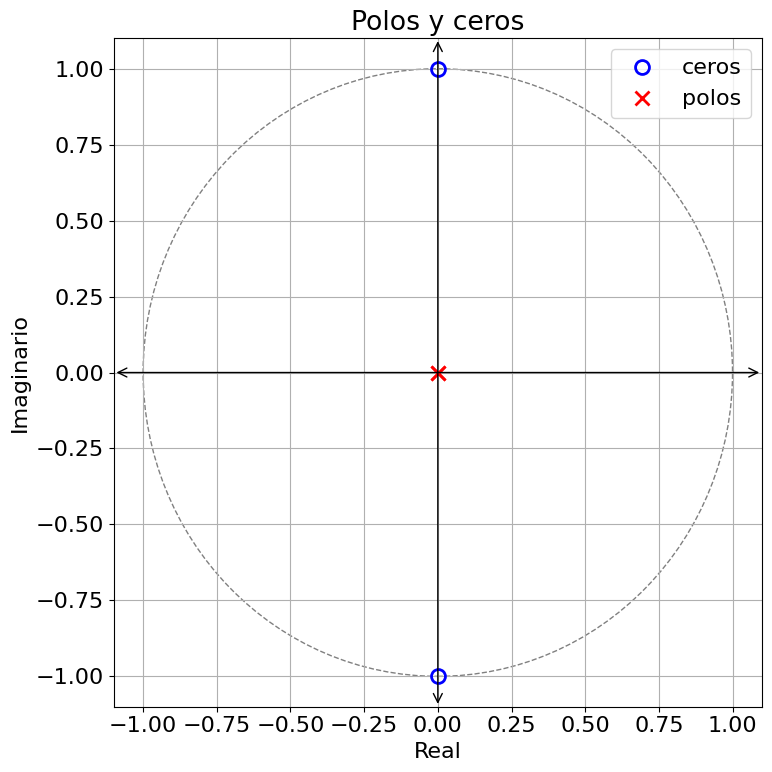

In [6]:
# planteamos dos vectores para no perder generalidad en los siguientes ejemplos
bm =  np.array([1, 0, 1])
an =  np.array([1, 0, 0])

# planteamos una fs = 2 Hz, de modo tal que Nyqyuist = 1 Hz y tengamos el 
# "ancho de banda" digital normalizado.
fs = 2
my_df = sig.TransferFunction(bm, an, dt=1/fs)
plot_frequency_response(my_df)



Claramente estamos ante una transferencia de tipo **notch**, en este caso con su cero de transmisión fijo a mitad de banda digital, o $f_s/4$. Ciertamente ahora la tasa de sobremuestreo $U$ es un nuevo parámetro del filtro, que podría ser modificado para obtener nuevas transferencias. En los siguientes ejemplos probaremos otros valores de $U$ tanto para $ H_{lp}(z) $ como para $ H_{hp}(z) $.

### Pasabajos interpolado

Comencemos con el pasabajo interpolado, que da lugar a un tipo de filtro llamado peine (comb en inglés) que tiene la particularidad que tiene ceros espaciados por un factor entero que depende del parámetro $U$. Esto suele ser útil para estimación o cancelación de una portadora y sus respectivas armónicas. 
Observar que:
* para U impar, este filtro peine tendrá un cero de transmisión en Nyquist y en diferentes armónicas que dependerán de $(k+1).\frac{fs}{2.U}$, y 
* para U pares, solo tendrá ceros equiespaciados en $(k+1).\frac{fs}{2.U}$ para $k=0, 1, ..., U-1 $

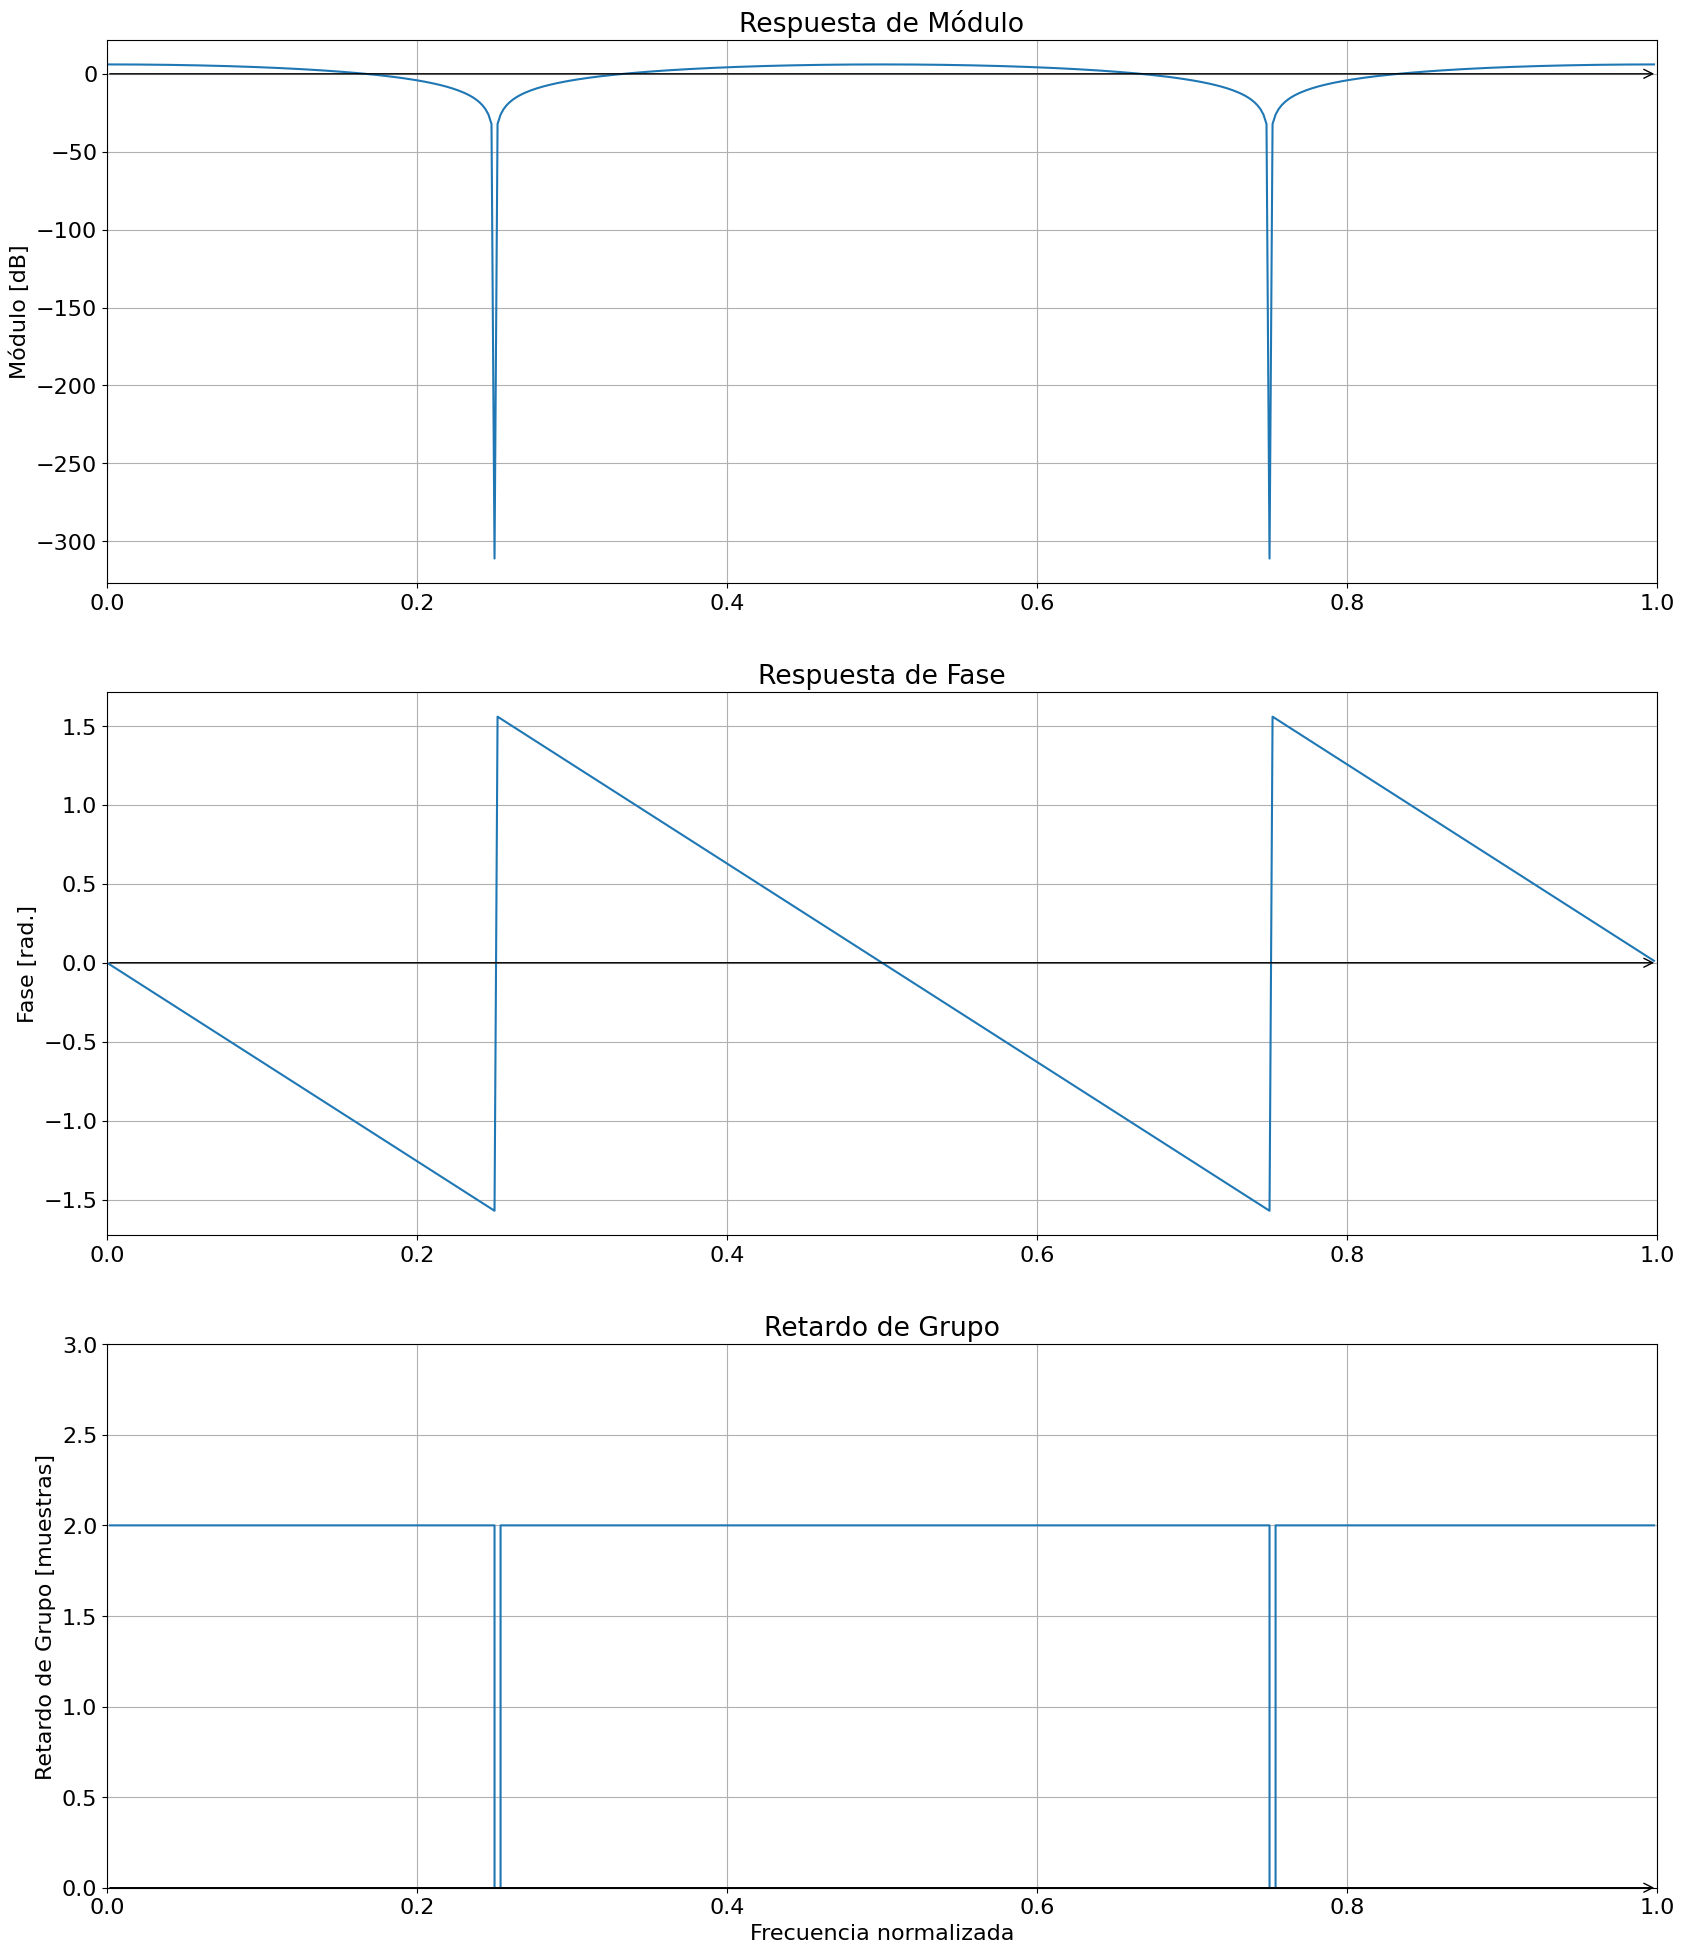

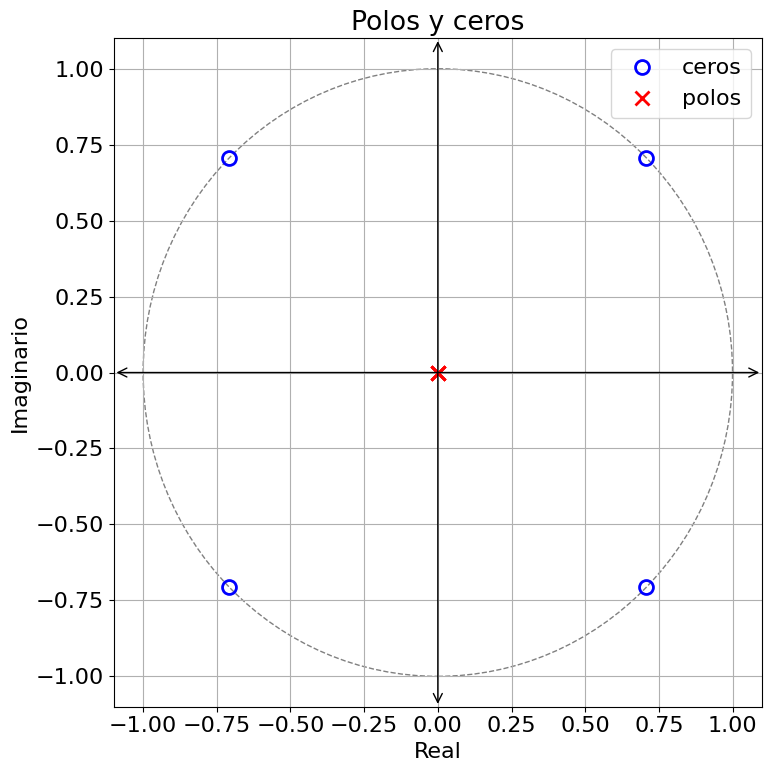

In [7]:
# planteamos dos vectores para no perder generalidad en los siguientes ejemplos

U = 4
bm =  np.hstack([1, np.zeros(U-1), 1])
an =  np.hstack([1, np.zeros(U-1), 0])

# planteamos una fs = 2 Hz, de modo tal que Nyqyuist = 1 Hz y tengamos el 
# "ancho de banda" digital normalizado.
fs = 2
my_df = sig.TransferFunction(bm, an, dt=1/fs)
plot_frequency_response(my_df)



### Pasa-altas interpolado

Finalmente el pasa-altas interpolado también resulta en un filtro peine con las siguientes características:
* para U impar, este filtro peine tendrá un cero de transmisión en DC y en armónicas múltiplos de $k.\frac{fs}{U}$, y 
* para U pares, tendrá ceros en DC y Nyquist, como también en múltiplos de $k.\frac{fs}{U}$ para $k=0, 1, ..., U-1 $

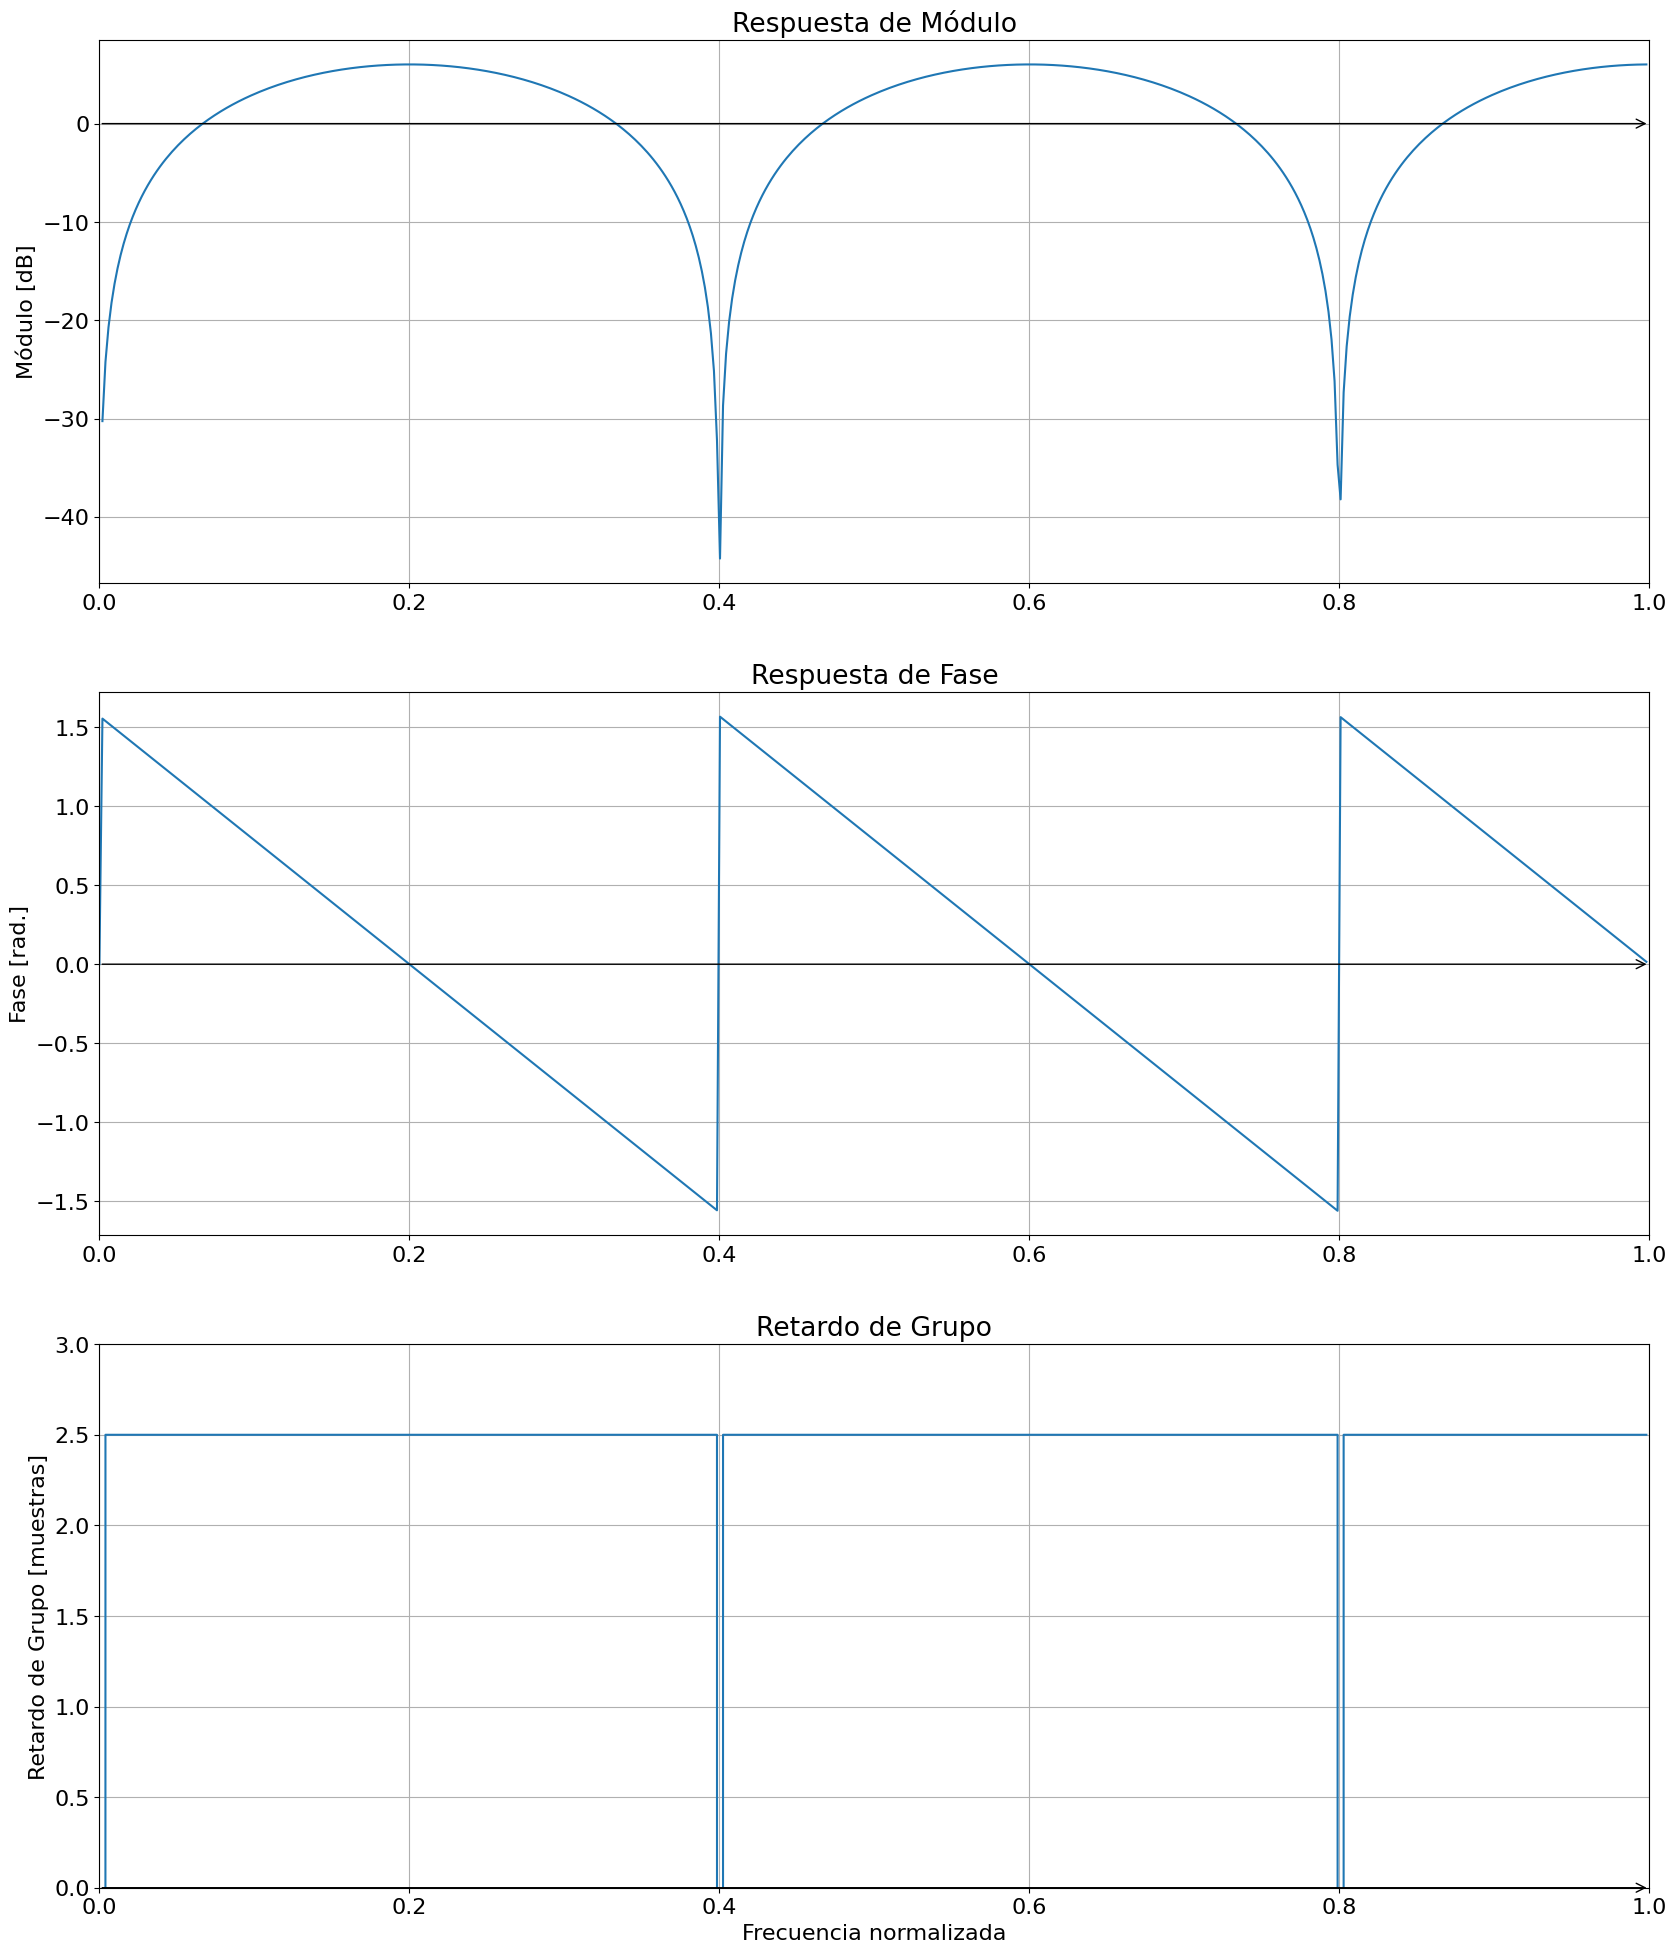

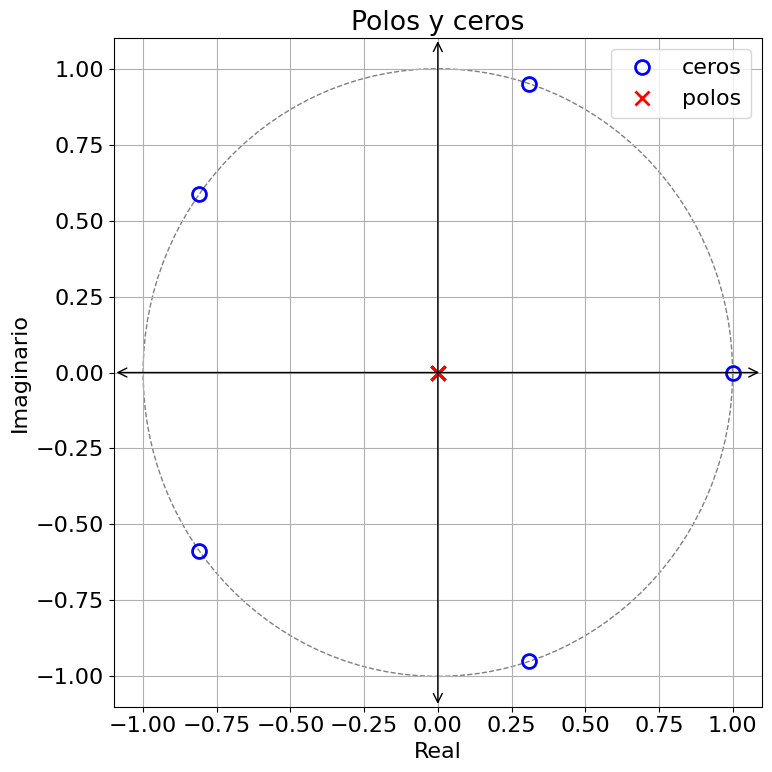

In [8]:
U = 5
bm =  np.hstack([1, np.zeros(U-1), -1])
an =  np.hstack([1, np.zeros(U-1), 0])

# planteamos una fs = 2 Hz, de modo tal que Nyqyuist = 1 Hz y tengamos el 
# "ancho de banda" digital normalizado.
fs = 2
my_df = sig.TransferFunction(bm, an, dt=1/fs)
plot_frequency_response(my_df)



## Resumen y comentarios finales

En este notebook se presentaron algunas herramientas útiles para la simulación de transferencias de filtros digitales FIR. Si bien las herramientas son aplicables a cualquier sistema muestreado, su extensión debe hacerse con ciertos cuidados dependiendo de la estructura a analizar. Se trabajará más sobre esta cuestión en los siguientes notebooks.

Se sugiere a quien tenga interés, revisar los [conceptos teóricos de los filtros FIR:](https://www.youtube.com/watch?v=RHIQ7O6TR3Q&list=PLlD2eDv5CIe9_QZtKGEPw5LtQRD3xaAnV&index=13)
* [respuesta de módulo y fase](https://www.youtube.com/watch?v=RHIQ7O6TR3Q&list=PLlD2eDv5CIe9_QZtKGEPw5LtQRD3xaAnV&index=14)
* [fase lineal y simetría](https://youtu.be/OLCn070fkzA?list=PLlD2eDv5CIe9_QZtKGEPw5LtQRD3xaAnV&t=851)
* [tipos de filtros FIR respecto a simetría y soporte](https://youtu.be/OLCn070fkzA?list=PLlD2eDv5CIe9_QZtKGEPw5LtQRD3xaAnV&t=1529) 

La interpolación de una respuesta en frecuencia puede pensarse como una redefinición o cambio arbitrario de la frecuencia de muestreo. Es decir, si recordamos el ejemplo del pasa-altas interpolado para $U=5$, tendremos 5 ceros equiespaciados en la circunferencia unitaria

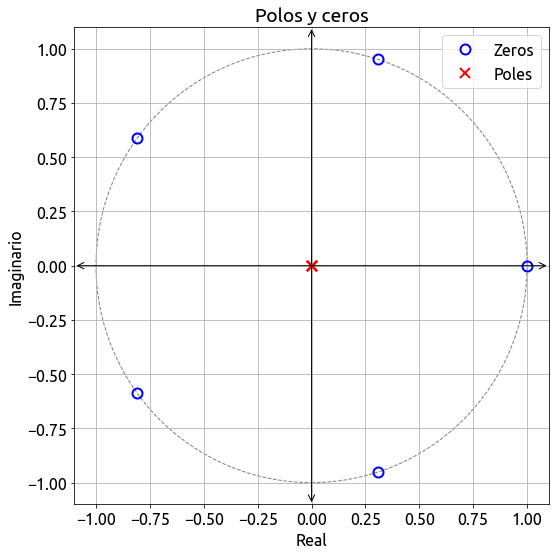

dando una respuesta de módulo

<img src="./interpolacion transferencia.png" align="center" width="95%" /> 

Comenzando por la frecuencia de Nyquist para $U=5$ ($F_{N5}$) en la extrema derecha. Podemos ver la respuesta original del pasa-altas para $U=1$, imaginando que ahora redefinimos la frecuencia de Nyq. al lugar que ocupa $F_{N1}$ (área sombreada en rojo). Se repite para cada valor de U obteniendo las diferentes $F_{Ni}$

De esta manera, podemos reinterpretar el efecto que conlleva interpolar $U$ veces una respuesta $H(z)$, como se aprecia más arriba, consiste en *comprimir* la respuesta y sus réplicas (o alias) U veces dentro del ancho de banda digital. En este momento sería bueno volver al script de análisis del pasa-altas interpolado para experimentar con diferentes valores de sobremuestreo $U$.